In [1]:
import tensorflow as tf
import numpy as np
import time
import cv2
import os
from pathlib import Path
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configurar estilo dos gráficos com fundo branco
plt.style.use('default')  # Usar estilo padrão (fundo branco)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

2025-06-13 13:36:18.146532: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 13:36:18.149738: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 13:36:18.160039: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 13:36:18.182962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749832578.224398   77511 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749832578.23

In [2]:
class TFLiteBenchmarkWithDataset:
    def __init__(self, model_path, model_display_name=None):
        self.model_path = model_path
        self.model_display_name = model_display_name or self._extract_model_name(model_path)
        self.interpreter = tf.lite.Interpreter(model_path=str(model_path))
        self.interpreter.allocate_tensors()
        
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.input_shape = self.input_details[0]['shape']
    
    def _extract_model_name(self, model_path):
        """Extrai e formata o nome do modelo"""
        filename = Path(model_path).stem.lower()
        
        # Mapeamento de nomes
        name_mapping = {
            'mobilenetv3': 'MobileNetV3',
            'efficientnetb0': 'EfficientNetB0',
            'lcnn': 'LCNN',
            'resnet': 'ResNet',
            'densenet': 'DenseNet',
            'vgg': 'VGG'
        }
        
        # Procurar por correspondências
        for key, display_name in name_mapping.items():
            if key in filename:
                return display_name
        
        # Se não encontrou, capitalize o nome do arquivo
        return filename.replace('_', ' ').title()
        
    def load_dataset_images(self, dataset_path, num_samples=100):
        """Carrega imagens do dataset MangoLeaf"""
        dataset_path = Path(dataset_path)
        all_images = []
        
        # Classes esperadas
        classes = ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 
                  'Die_Back', 'Gall_Midge', 'Healthy', 'Powdery_Mildew', 'Sooty_Mould']
        
        print(f"Carregando imagens de {dataset_path}")
        
        for class_name in classes:
            class_path = dataset_path / class_name
            if class_path.exists():
                image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
                all_images.extend([(img_path, class_name) for img_path in image_files])
                print(f"  {class_name}: {len(image_files)} imagens")
        
        random.shuffle(all_images)
        selected_images = all_images[:min(num_samples, len(all_images))]
        
        print(f"Total de imagens selecionadas: {len(selected_images)}")
        return selected_images
    
    def preprocess_image(self, image_path):
        """Preprocessa imagem para o modelo"""
        try:
            img = cv2.imread(str(image_path))
            if img is None:
                return None
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            target_size = (self.input_shape[1], self.input_shape[2])
            img = cv2.resize(img, target_size)
            
            if self.input_details[0]['dtype'] == np.float32:
                img = img.astype(np.float32) / 255.0
            else:
                img = img.astype(np.uint8)
            
            img = np.expand_dims(img, axis=0)
            return img
            
        except Exception as e:
            print(f"Erro ao processar {image_path}: {e}")
            return None
    
    def single_inference(self, input_data):
        """Run single inference and return latency"""
        start_time = time.perf_counter()
        
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)
        self.interpreter.invoke()
        output = self.interpreter.get_tensor(self.output_details[0]['index'])
        
        end_time = time.perf_counter()
        return end_time - start_time, output
    
    def benchmark_with_real_data(self, dataset_path, num_warmup=10, num_runs=100):
        """Benchmark usando dataset real de manga"""
        print(f"\n=== Benchmarking {self.model_display_name} com dataset real ===")
        
        selected_images = self.load_dataset_images(dataset_path, num_runs + num_warmup)
        
        if len(selected_images) < num_runs:
            print(f"⚠️  Apenas {len(selected_images)} imagens disponíveis, ajustando num_runs")
            num_runs = len(selected_images) - num_warmup
        
        preprocessed_images = []
        class_distribution = defaultdict(int)
        
        print("Preprocessando imagens...")
        for img_path, class_name in selected_images:
            processed_img = self.preprocess_image(img_path)
            if processed_img is not None:
                preprocessed_images.append((processed_img, class_name))
                class_distribution[class_name] += 1
        
        print("Distribuição das classes no benchmark:")
        for class_name, count in class_distribution.items():
            print(f"  {class_name}: {count} imagens")
        
        # Warmup
        print(f"Executando {num_warmup} warmup runs...")
        for i in range(num_warmup):
            img, _ = preprocessed_images[i]
            _, _ = self.single_inference(img)
        
        # Benchmark real
        print(f"Executando {num_runs} benchmark runs...")
        latencies = []
        
        for i in range(num_warmup, num_warmup + num_runs):
            if (i - num_warmup + 1) % 20 == 0:
                print(f"  Progress: {i - num_warmup + 1}/{num_runs}")
            
            img, class_name = preprocessed_images[i]
            latency, _ = self.single_inference(img)
            latencies.append(latency * 1000)  # Convert to ms
        
        # Calcular estatísticas
        stats = {
            'model_name': self.model_display_name,
            'dataset_used': 'MangoLeaf_Real_Data',
            'num_runs': num_runs,
            'mean_ms': np.mean(latencies),
            'std_ms': np.std(latencies),
            'min_ms': np.min(latencies),
            'max_ms': np.max(latencies),
            'p50_ms': np.percentile(latencies, 50),
            'p95_ms': np.percentile(latencies, 95),
            'p99_ms': np.percentile(latencies, 99),
            'fps': 1000 / np.mean(latencies),
            'input_shape': self.input_shape.tolist(),
            'class_distribution': dict(class_distribution)
        }
        
        return stats, latencies

In [3]:
def benchmark_mango_models(model_paths, dataset_path, num_runs=100, custom_names=None):
    """Benchmark múltiplos modelos com dataset de manga"""
    all_results = []
    all_latencies = {}
    
    # Nomes personalizados se fornecidos
    if custom_names is None:
        custom_names = [None] * len(model_paths)
    
    for i, model_path in enumerate(model_paths):
        if not Path(model_path).exists():
            print(f"⚠️  Modelo {model_path} não encontrado!")
            continue
            
        try:
            benchmark = TFLiteBenchmarkWithDataset(Path(model_path), custom_names[i])
            stats, latencies = benchmark.benchmark_with_real_data(dataset_path, num_runs=num_runs)
            
            all_results.append(stats)
            all_latencies[stats['model_name']] = latencies
            
            # Print results
            print(f"\n--- Resultados para {stats['model_name']} ---")
            print(f"Dataset: {stats['dataset_used']}")
            print(f"Latência média: {stats['mean_ms']:.2f} ± {stats['std_ms']:.2f} ms")
            print(f"P95 latência: {stats['p95_ms']:.2f} ms")
            print(f"Throughput: {stats['fps']:.1f} FPS")
            
        except Exception as e:
            print(f"Erro no benchmark de {model_path}: {e}")
    
    return all_results, all_latencies

In [7]:
# Configuração dos modelos
model_paths = [
    "models/compressed/MobileNetV3 Small.tflite",
    "models/compressed/EfficientNetB0.tflite", 
    "models/compressed/LCNN.tflite"
]

# Nomes personalizados (opcional)
custom_names = ["MobileNetV3", "EfficientNetB0", "LCNN"]

# Caminho do dataset
dataset_path = "../../MangoLeaf"

print("Benchmark TFLite com Dataset MangoLeaf")
print("=" * 50)

# Executar benchmark (só execute uma vez!)
results, latencies = benchmark_mango_models(
    model_paths=model_paths,
    dataset_path=dataset_path,
    num_runs=100,
    custom_names=custom_names
)

# Salvar resultados para evitar perder dados
import pickle
with open('../../v2/results/benchmark_results.pkl', 'wb') as f:
    pickle.dump((results, latencies), f)

print("\n✅ Benchmark concluído! Resultados salvos em 'benchmark_results.pkl'")

Benchmark TFLite com Dataset MangoLeaf

=== Benchmarking MobileNetV3 com dataset real ===
Carregando imagens de ../../MangoLeaf
  Anthracnose: 500 imagens
  Healthy: 500 imagens
Total de imagens selecionadas: 110
Preprocessando imagens...


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Distribuição das classes no benchmark:
  Anthracnose: 56 imagens
  Healthy: 54 imagens
Executando 10 warmup runs...
Executando 100 benchmark runs...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Resultados para MobileNetV3 ---
Dataset: MangoLeaf_Real_Data
Latência média: 6.46 ± 2.41 ms
P95 latência: 9.71 ms
Throughput: 154.9 FPS

=== Benchmarking EfficientNetB0 com dataset real ===
Carregando imagens de ../../MangoLeaf
  Anthracnose: 500 imagens
  Healthy: 500 imagens
Total de imagens selecionadas: 110
Preprocessando imagens...
Distribuição das classes no benchmark:
  Healthy: 52 imagens
  Anthracnose: 58 imagens
Executando 10 warmup runs...
Executando 100 benchmark runs...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Resultados para EfficientNetB0 ---
Dataset: MangoLeaf_Real_Data
Latência média: 59.22 ± 12.46 ms
P95 latência: 78.10 ms
Throughput: 16.9 FPS

=== Benchmarking LC

In [8]:
# Execute esta célula se quiser carregar resultados salvos
import pickle

try:
    with open('../../v2/results/benchmark_results.pkl', 'rb') as f:
        results, latencies = pickle.load(f)
    print("✅ Resultados carregados com sucesso!")
    
    # Mostrar resumo
    for result in results:
        print(f"{result['model_name']}: {result['mean_ms']:.2f}ms, {result['fps']:.1f} FPS")
        
except FileNotFoundError:
    print("❌ Arquivo de resultados não encontrado. Execute o benchmark primeiro.")

✅ Resultados carregados com sucesso!
MobileNetV3: 6.46ms, 154.9 FPS
EfficientNetB0: 59.22ms, 16.9 FPS
LCNN: 26.49ms, 37.8 FPS


/tmp/ipykernel_77511/129987135.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(latency_data, labels=model_names, patch_artist=True,


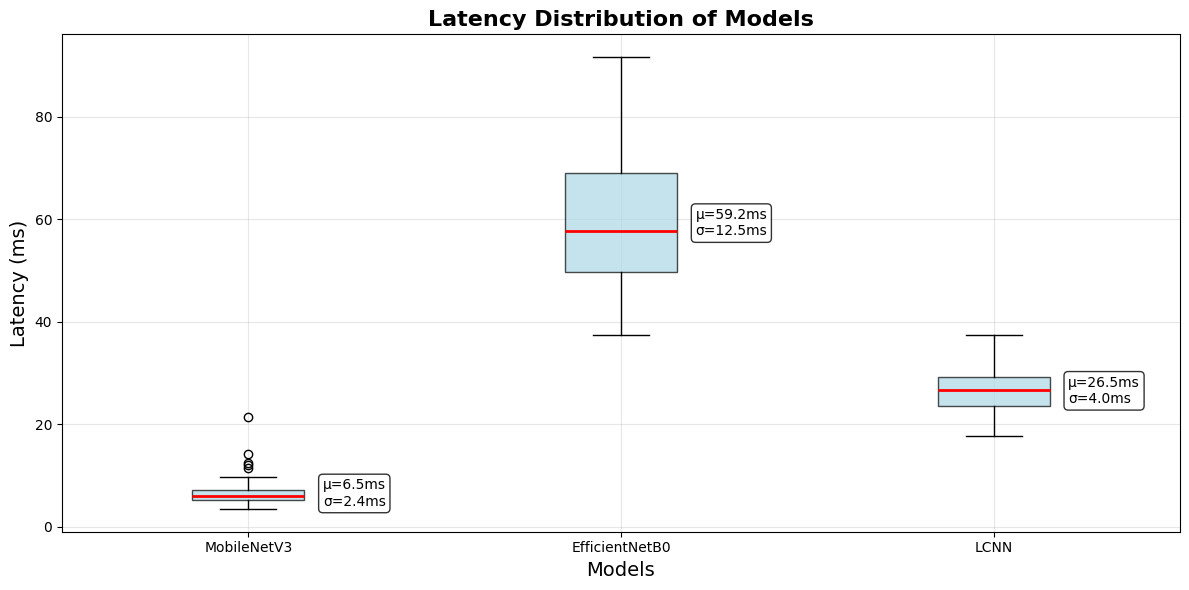

📊 Gráfico salvo como 'latency_distribution.png'


In [9]:
def plot_latency_distribution(results, latencies):
    """Plota a distribuição de latência"""
    plt.figure(figsize=(12, 6))
    
    latency_data = []
    model_names = []
    
    for result in results:
        model_name = result['model_name']
        if model_name in latencies:
            latency_data.append(latencies[model_name])
            model_names.append(model_name)
    
    # Criar boxplot
    box_plot = plt.boxplot(latency_data, labels=model_names, patch_artist=True, 
                          boxprops=dict(facecolor='lightblue', alpha=0.7),
                          medianprops=dict(color='red', linewidth=2))
    
    plt.title('Latency Distribution of Models', fontsize=16, fontweight='bold')
    plt.ylabel('Latency (ms)', fontsize=14)
    plt.xlabel('Models', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=0)
    
    # Adicionar estatísticas
    for i, result in enumerate(results):
        if result['model_name'] in latencies:
            x_pos = i + 1.2 
            y_pos = result['mean_ms']
            
            stats_text = f"μ={result['mean_ms']:.1f}ms\nσ={result['std_ms']:.1f}ms"
            
            plt.text(x_pos, y_pos, stats_text,
                    ha='left', va='center', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('../../v2/results/latency_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Gráfico salvo como 'latency_distribution.png'")

# Execute para plotar
if 'results' in locals() and 'latencies' in locals():
    plot_latency_distribution(results, latencies)
else:
    print("❌ Execute o benchmark ou carregue os resultados primeiro!")

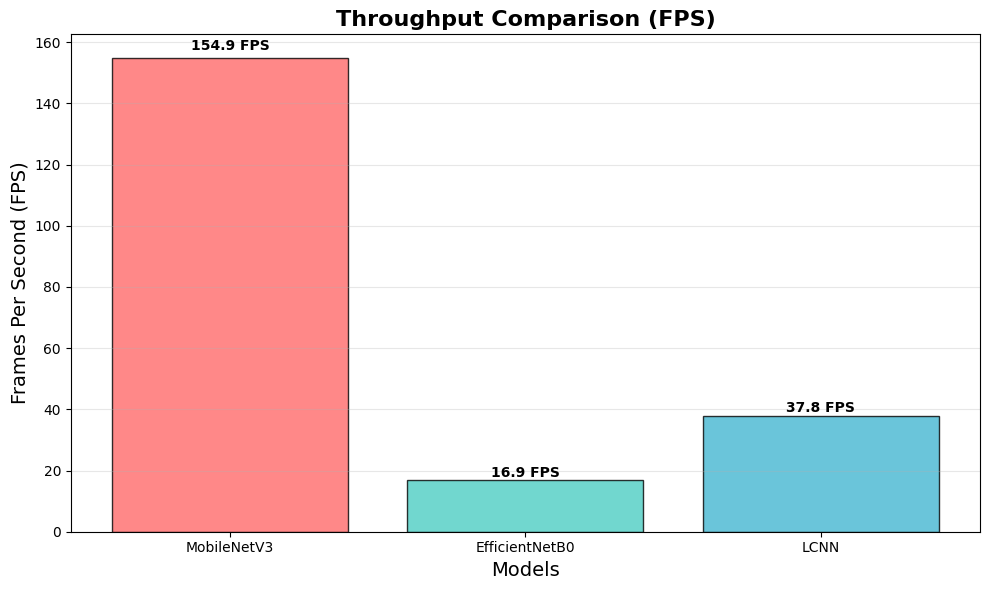

🚀 Gráfico salvo como 'fps_comparison.png'


In [10]:
def plot_fps_comparison(results, show_threshold=False, threshold_fps=30):
    """Plota comparação de FPS"""
    plt.figure(figsize=(10, 6))
    
    model_names = [result['model_name'] for result in results]
    fps_values = [result['fps'] for result in results]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'][:len(model_names)]
    
    bars = plt.bar(model_names, fps_values, color=colors, alpha=0.8, 
                   edgecolor='black', linewidth=1)
    
    plt.title('Throughput Comparison (FPS)', fontsize=16, fontweight='bold')
    plt.ylabel('Frames Per Second (FPS)', fontsize=14)
    plt.xlabel('Models', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=0)
    
    # Adicionar valores nas barras
    for bar, fps in zip(bars, fps_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{fps:.1f} FPS', ha='center', va='bottom', fontweight='bold')
    
    # Linha de threshold para tempo real
    if show_threshold:
        plt.axhline(y=threshold_fps, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(0.02, threshold_fps + 2, f'Real-time threshold ({threshold_fps} FPS)', 
                transform=plt.gca().get_yaxis_transform(),
                color='red', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../../v2/results/fps_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("🚀 Gráfico salvo como 'fps_comparison.png'")

# Execute para plotar (com ou sem threshold)
if 'results' in locals():
    plot_fps_comparison(results, show_threshold=False, threshold_fps=30)
else:
    print("❌ Execute o benchmark ou carregue os resultados primeiro!")

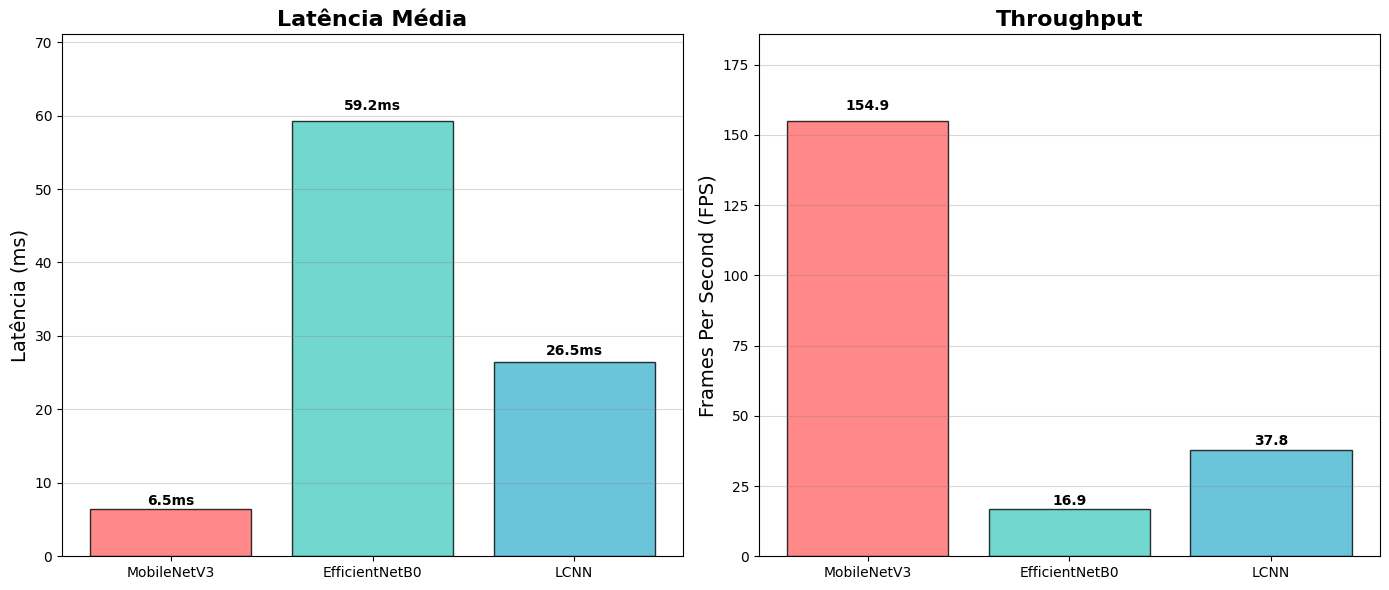

📊 Comparação simples salva como 'simple_comparison.png'


In [11]:
def plot_simple_comparison(results):
    """Plota comparação simples e limpa"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')
    
    model_names = [result['model_name'] for result in results]
    mean_latencies = [result['mean_ms'] for result in results]
    fps_values = [result['fps'] for result in results]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'][:len(model_names)]
    
    # Definir fundo branco
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')
    
    # Gráfico 1: Latência
    bars1 = ax1.bar(model_names, mean_latencies, color=colors, alpha=0.8, 
                    edgecolor='black', linewidth=1)
    ax1.set_title('Latência Média', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Latência (ms)', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='y', color='gray')
    ax1.set_ylim(0, max(mean_latencies) * 1.2)
    
    # Adicionar valores
    for bar, value in zip(bars1, mean_latencies):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.02,
                f'{value:.1f}ms', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico 2: FPS
    bars2 = ax2.bar(model_names, fps_values, color=colors, alpha=0.8, 
                    edgecolor='black', linewidth=1)
    ax2.set_title('Throughput', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Frames Per Second (FPS)', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y', color='gray')
    ax2.set_ylim(0, max(fps_values) * 1.2)
    
    # Adicionar valores
    for bar, value in zip(bars2, fps_values):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.02,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../../v2/results/simple_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("📊 Comparação simples salva como 'simple_comparison.png'")

# Execute para plotar versão simples
if 'results' in locals():
    plot_simple_comparison(results)
else:
    print("❌ Execute o benchmark ou carregue os resultados primeiro!")